In [1]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

from model.my_model import initialize_model, SmallModel, eval_suite
from train import get_dataloaders
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

/Users/charliesnell/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
model_name = 'resnet'
num_classes = 10
feature_extract = False
# model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)
model_ft = SmallModel(num_classes, 32, 32, 3)

# Print the model we just instantiated
print(model_ft)

# Data Loaders
data_loaders = get_dataloaders('cifar10', 'project/data', 32)
model_ft.eval()

SmallModel(
  (convs): Sequential(
    (0): Conv2d(3, 10, kernel_size=(5, 5), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
    (4): Dropout2d(p=0.5, inplace=False)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): ReLU()
  )
  (fc1): Linear(in_features=500, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)
Files already downloaded and verified
Files already downloaded and verified


SmallModel(
  (convs): Sequential(
    (0): Conv2d(3, 10, kernel_size=(5, 5), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
    (4): Dropout2d(p=0.5, inplace=False)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): ReLU()
  )
  (fc1): Linear(in_features=500, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)

In [4]:
def collect_val_stats(model, dataloader, label_names):
    model.eval()
    predicts_history = []
    ys_history = []
    for inputs, labels in dataloader:
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        predicts_history.extend(preds.clone().detach().cpu().numpy().tolist())
        ys_history.extend(labels.clone().detach().cpu().numpy().tolist())
    return eval_suite(np.array(predicts_history), np.array(ys_history), label_names)

In [5]:
evals = collect_val_stats(model_ft, data_loaders['val'], data_loaders['label_names'])
print(evals)

{'accuracy': 0.1001, 'confusion_matrix': array([[   0.,    0.,  999.,    0.,    0.,    0.,    0.,    0.,    0.,
           1.],
       [   0.,    0.,  996.,    0.,    0.,    0.,    0.,    0.,    0.,
           4.],
       [   0.,    0.,  999.,    0.,    0.,    0.,    0.,    0.,    0.,
           1.],
       [   0.,    0.,  999.,    0.,    0.,    0.,    0.,    0.,    0.,
           1.],
       [   0.,    0.,  999.,    0.,    0.,    0.,    0.,    0.,    0.,
           1.],
       [   0.,    0.,  999.,    0.,    0.,    0.,    0.,    0.,    0.,
           1.],
       [   0.,    0., 1000.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.],
       [   0.,    0., 1000.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.],
       [   0.,    0.,  998.,    0.,    0.,    0.,    0.,    0.,    0.,
           2.],
       [   0.,    0.,  998.,    0.,    0.,    0.,    0.,    0.,    0.,
           2.]]), 'label_names': ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse'

/Users/charliesnell/current_projects/project-t/project/model/my_model.py:41: RuntimeWarning: invalid value encountered in double_scalars
  precision = TPs / (TPs + FPs)


In [6]:
df_cm = pd.DataFrame(evals['confusion_matrix'], index=evals['label_names'], columns=evals['label_names'])

In [7]:
df_cm

,airplane,automobile,bird,cat,deer,dog,frog,horse,ship,truck
airplane,0.0,0.0,999.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
automobile,0.0,0.0,996.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
bird,0.0,0.0,999.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
cat,0.0,0.0,999.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
deer,0.0,0.0,999.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
dog,0.0,0.0,999.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
frog,0.0,0.0,1000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
horse,0.0,0.0,1000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ship,0.0,0.0,998.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
truck,0.0,0.0,998.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0


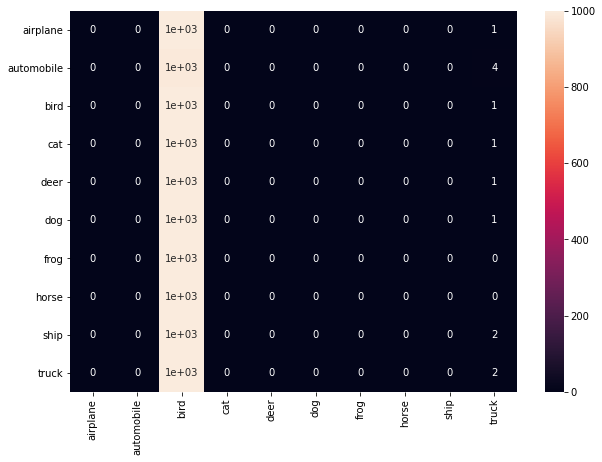

In [8]:
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)